In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from scipy.io import savemat, loadmat
from nilearn import datasets, plotting, image

In [11]:
DIR = '/trinity/home/g.bobrovskih/ongoing/neuro-gnn-project/datasets' 

**Loading atlas**

In [3]:
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas['maps']
labels = atlas['labels']
coords = atlas['region_coords']
networks = atlas['networks'] # len == len(labels)
print('>ROI labels', labels, len(labels))
print('>Brain networks labels', list(np.unique(networks)), len(np.unique(networks)))


Dataset created in /trinity/home/g.bobrovskih/nilearn_data/msdl_atlas



 ...done. (1 seconds, 0 min)
Extracting data from /trinity/home/g.bobrovskih/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.


>ROI labels ['L Aud', 'R Aud', 'Striate', 'L DMN', 'Med DMN', 'Front DMN', 'R DMN', 'Occ post', 'Motor', 'R DLPFC', 'R Front pol', 'R Par', 'R Post Temp', 'Basal', 'L Par', 'L DLPFC', 'L Front pol', 'L IPS', 'R IPS', 'L LOC', 'Vis', 'R LOC', 'D ACC', 'V ACC', 'R A Ins', 'L STS', 'R STS', 'L TPJ', 'Broca', 'Sup Front S', 'R TPJ', 'R Pars Op', 'Cereb', 'Dors PCC', 'L Ins', 'Cing', 'R Ins', 'L Ant IPS', 'R Ant IPS'] 39
>Brain networks labels ['Ant IPS', 'Aud', 'Basal', 'Cereb', 'Cing-Ins', 'D Att', 'DMN', 'Dors PCC', 'L V Att', 'Language', 'Motor', 'Occ post', 'R V Att', 'Salience', 'Striate', 'Temporal', 'Vis Sec'] 17


In [4]:
labels_map = {val: i for i, val in enumerate(labels)}
networks_map = {val: i for i, val in enumerate(np.array(networks)[np.sort(np.unique(networks, return_index=True)[1])])} # return map: net->num, enumerated in the same order as labels

**Loading connectivity data**

In [6]:
data = pd.read_csv('{DIR}/func_conn.csv')
data.head()

,file,ID,target,Sex,L Aud-R Aud,L Aud-Striate,R Aud-Striate,L Aud-L DMN,R Aud-L DMN,Striate-L DMN,...,Broca-R Ant IPS,Sup Front S-R Ant IPS,R TPJ-R Ant IPS,R Pars Op-R Ant IPS,Cereb-R Ant IPS,Dors PCC-R Ant IPS,L Ins-R Ant IPS,Cing-R Ant IPS,R Ins-R Ant IPS,L Ant IPS-R Ant IPS
0,morphometry_A00007409,A00007409,No_Known_Disorder,male,0.852745,0.472408,0.438451,-0.151586,-0.175817,-0.088072,...,0.157520,0.111554,0.024794,0.074087,0.083605,0.332223,0.299678,0.378165,0.238186,0.633913
1,morphometry_A00031597,A00031597,Schizophrenia_Strict,male,0.748457,0.532091,0.617542,0.090878,0.043540,-0.036074,...,0.374588,0.340460,0.342494,0.249617,0.382124,0.604362,0.168657,0.284299,0.183674,0.626664
2,morphometry_A00022500,A00022500,Schizophrenia_Strict,female,0.592125,0.036093,0.133537,0.082847,0.179051,0.314248,...,-0.253343,-0.049419,0.103218,-0.098405,-0.106043,0.359292,-0.283070,0.194902,-0.112684,0.582636
3,morphometry_A00024953,A00024953,Schizophrenia_Strict,male,0.780837,0.354871,0.420179,0.144601,0.208352,0.168114,...,0.190040,-0.012739,-0.038590,0.150418,0.043712,0.165942,-0.003737,0.316817,-0.003129,0.633039
4,morphometry_A00001251,A00001251,Schizophrenia_Strict,male,0.447026,-0.024045,0.432331,-0.247530,0.113947,0.412405,...,-0.240672,0.271395,-0.054881,0.044233,0.063376,0.387130,0.145573,0.396055,0.112810,0.532662


In [7]:
def get_adjmat(patient):
    connectivity_mat = np.zeros((len(labels), len(labels)))
    for i, name1 in enumerate(labels_map.keys()):
        for name2 in list(labels_map.keys())[(i+1):]: # skipping past and skipping itself
            col_name = f'{name1}-{name2}' if f'{name1}-{name2}' in patient.columns else None
            col_name = f'{name2}-{name1}' if (f'{name2}-{name1}' in patient.columns and col_name is None) else col_name
            if col_name is not None:
                connectivity_mat[labels_map[name1]][labels_map[name2]] = patient[col_name]
                connectivity_mat[labels_map[name2]][labels_map[name1]] = patient[col_name]
                
    return connectivity_mat

**Connectivity matrix example**

In [8]:
patient_0 = pd.DataFrame(data.iloc[0]).T
connectivity_mat = get_adjmat(patient_0)
print(connectivity_mat.shape)

(39, 39)


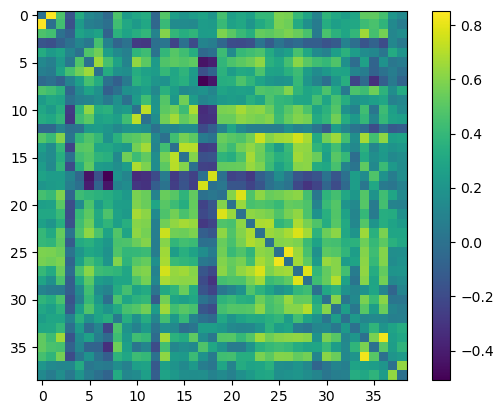

In [9]:
plt.imshow(connectivity_mat)
plt.colorbar()

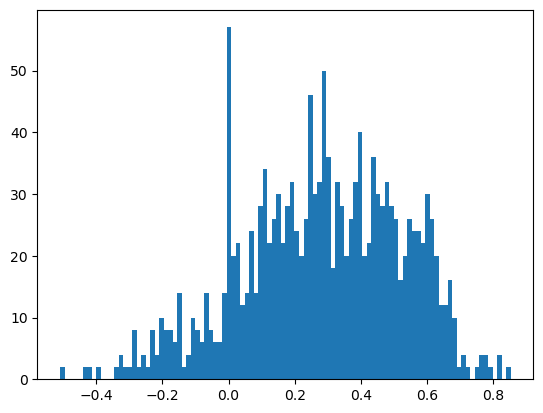

In [10]:
plt.hist(connectivity_mat.reshape(-1), bins=100);

In [14]:

# 1. TODO: explain
labels_nets = zip(labels, networks)
pd.DataFrame(list(labels_nets), columns=['label', 'network']).to_csv(f'{DIR}/Schiza_Community.csv')

# 2. TODO: explain
node_size = 1
with open(f'{DIR}/Schiza.txt', 'w') as f:
    for i, (vertice, cluster) in enumerate(labels_nets):
        x, y, z = atlas['region_coords'][i]
        f.write(f'{x}\t{y}\t{z}\t{networks_map[cluster]}\t{node_size}\t{labels_map[vertice]}\t\n')


**IBGNN input**
* Connectivity matrices
* Node labels, format: txt, file with rows: (x, y, z), node color (cluster), node size, node unique name/label
* Community, format: csv, file with rows: id, node label, community label (for heatmap)

In [15]:
# conver targets from schizoaffective/schizo_strict to schizo
targets = data['target']
print(np.unique(targets))

data_schizastrict = data.drop(data[data['target'] == 'Schizoaffective'].index, axis='index')
targets_schizastrict = data_schizastrict['target']
targets_bin = [1. if ('Schizo' in l) else 0. for l in targets_schizastrict]

['No_Known_Disorder' 'Schizoaffective' 'Schizophrenia_Strict']


In [16]:
connectivity_data = np.asarray(list([get_adjmat(pd.DataFrame(data_schizastrict.iloc[i]).T) for i in range(data_schizastrict.shape[0])]))
assert len(connectivity_data.shape) == 3
assert connectivity_data.shape[1:] == (39, 39)
savemat(f'{DIR}/Schiza.mat', {'label': targets_bin, 'dti': connectivity_data.T})

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_results(idx, type='negative', dir=None, seed=None):

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

#     im0 = axs[0, 0].imshow(connectivity_mat)
    connectivity_mat = np.loadtxt(f'./IBGNN_modified/fig/{dir}/explainer_input_{idx}_{type}.txt')
    im0 = axs[0, 0].imshow(connectivity_mat)
    axs[0, 0].set_title('patient input connectivity')
    divider = make_axes_locatable(axs[0, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical');

    im1 = axs[0, 1].imshow(general_edge_mask)
    axs[0, 1].set_title('general edge mask')
    divider = make_axes_locatable(axs[0, 1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical');


    im2 = axs[1, 0].imshow(general_edge_mask*connectivity_mat)
    axs[1, 0].set_title('edge mask * connectivity')
    divider = make_axes_locatable(axs[1, 0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');

    if seed is None:
        seed = 123457
    axs[1, 1].imshow(plt.imread(f'./IBGNN_modified//fig/{dir}//explained_Schiza_seed{seed}_{type}_{idx}_heatmap.png')[190:, 300:1950])
    axs[1, 1].set_title('edge mask * connectivity thresholded')

    fig.tight_layout()
    fig.suptitle('Schizo patient', fontsize=16);


**Run Training + extracting explaination**

(128, 4, 4) ==> 74 accuracy
(256, 5, 5) ==> 66 accuracy

In [26]:
# default parameters
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/bda456a5fd1041fbbf0af89f77230bc8

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/bda456a5fd1041fbbf0af89f77230bc8
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename    

(Initial Train) | Epoch=062, loss=0.0891, 
train_micro=98.35, train_macro=98.34, train_auc=97.64
(Initial Train) | Epoch=063, loss=0.0830, 
train_micro=89.26, train_macro=89.23, train_auc=98.26
(Initial Train) | Epoch=064, loss=0.2001, 
train_micro=95.87, train_macro=95.85, train_auc=97.90
(Initial Train) | Epoch=065, loss=0.1444, 
train_micro=82.64, train_macro=81.80, train_auc=88.71
(Initial Train) | Epoch=066, loss=0.1704, 
train_micro=91.74, train_macro=91.61, train_auc=94.64
(Initial Train) | Epoch=067, loss=0.2166, 
train_micro=95.04, train_macro=95.00, train_auc=96.49
(Initial Train) | Epoch=068, loss=0.2687, 
train_micro=76.86, train_macro=76.14, train_auc=96.09
(Initial Train) | Epoch=069, loss=0.4545, 
train_micro=82.64, train_macro=82.47, train_auc=92.90
(Initial Train) | Epoch=070, loss=0.5968, 
train_micro=82.64, train_macro=81.80, train_auc=86.90
(Initial Train) | Epoch=071, loss=0.3081, 
train_micro=91.74, train_macro=91.61, train_auc=95.64
(Initial Train) | Epoch=072, l

(Tuning Train) | Epoch=040, loss=0.0271, 
train_micro=93.39, train_macro=93.29, train_auc=96.49
(Tuning Train) | Epoch=041, loss=0.0803, 
train_micro=95.04, train_macro=95.04, train_auc=99.84
(Tuning Train) | Epoch=042, loss=0.0099, 
train_micro=89.26, train_macro=88.95, train_auc=92.98
(Tuning Train) | Epoch=043, loss=0.0739, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=044, loss=0.0352, 
train_micro=95.87, train_macro=95.86, train_auc=98.82
(Tuning Train) | Epoch=045, loss=0.0112, 
train_micro=98.35, train_macro=98.34, train_auc=100.00
(Tuning Train) | Epoch=046, loss=0.0000, 
train_micro=96.69, train_macro=96.67, train_auc=100.00
(Tuning Train) | Epoch=047, loss=0.0056, 
train_micro=95.04, train_macro=95.04, train_auc=99.97
(Tuning Train) | Epoch=048, loss=0.0343, 
train_micro=95.87, train_macro=95.83, train_auc=100.00
(Tuning Train) | Epoch=049, loss=0.0340, 
train_micro=89.26, train_macro=89.23, train_auc=99.95
(Tuning Train) | Epoch=050, loss=0

COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Uploading 1 metrics, params and output messages


In [41]:
# default parameters
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza \
 --initial_epochs 50 --tuning_epochs 50 --explainer_epochs 500 --test_interval 10 \
 --dropout 0.5 --hidden_dim 32 --n_GNN_layers 2 --n_MLP_layers 2 --lr 0.001 --threshold 100

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/919c11759da141d6892d98df2a5abcbe

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/919c11759da141d6892d98df2a5abcbe
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename    

(Tuning Train) | Epoch=005, loss=0.0428, 
train_micro=65.29, train_macro=62.12, train_auc=76.70
(Tuning Train) | Epoch=006, loss=0.0540, 
train_micro=63.64, train_macro=62.27, train_auc=75.90
(Tuning Train) | Epoch=007, loss=0.0489, 
train_micro=57.02, train_macro=43.62, train_auc=77.91
(Tuning Train) | Epoch=008, loss=0.0513, 
train_micro=54.55, train_macro=52.35, train_auc=69.98
(Tuning Train) | Epoch=009, loss=0.0596, 
train_micro=62.81, train_macro=59.20, train_auc=68.06
(Tuning Train Epoch 9), test_micro=32.26, test_macro=31.11, test_auc=44.30

(Tuning Train) | Epoch=010, loss=0.0467, 
train_micro=68.60, train_macro=67.96, train_auc=77.82
(Tuning Train) | Epoch=011, loss=0.0430, 
train_micro=57.02, train_macro=53.10, train_auc=80.15
(Tuning Train) | Epoch=012, loss=0.0460, 
train_micro=66.94, train_macro=62.16, train_auc=79.91
(Tuning Train) | Epoch=013, loss=0.0436, 
train_micro=60.33, train_macro=58.25, train_auc=65.08
(Tuning Train) | Epoch=014, loss=0.0659, 
train_micro=43.80,

In [42]:
# default parameters
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza \
 --initial_epochs 50 --tuning_epochs 50 --explainer_epochs 500 --test_interval 10 \
 --dropout 0.5 --hidden_dim 64 --n_GNN_layers 2 --n_MLP_layers 2 --lr 0.001 --threshold 100

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/86160c025b9c407cbebadb1cb99dc776

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/86160c025b9c407cbebadb1cb99dc776
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filenam

(Tuning Train) | Epoch=006, loss=0.0000, 
train_micro=99.17, train_macro=99.17, train_auc=99.12
(Tuning Train) | Epoch=007, loss=0.0253, 
train_micro=98.35, train_macro=98.34, train_auc=99.12
(Tuning Train) | Epoch=008, loss=0.0178, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=009, loss=0.0014, 
train_micro=99.17, train_macro=99.17, train_auc=100.00
(Tuning Train Epoch 9), test_micro=64.52, test_macro=64.52, test_auc=71.93

(Tuning Train) | Epoch=010, loss=0.0233, 
train_micro=96.69, train_macro=96.69, train_auc=100.00
(Tuning Train) | Epoch=011, loss=0.0712, 
train_micro=93.39, train_macro=93.29, train_auc=94.74
(Tuning Train) | Epoch=012, loss=0.0206, 
train_micro=95.87, train_macro=95.87, train_auc=100.00
(Tuning Train) | Epoch=013, loss=0.0179, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=014, loss=0.0000, 
train_micro=99.17, train_macro=99.17, train_auc=99.12
(Tuning Train) | Epoch=015, loss=0.0181, 
train_mic

In [43]:
# default parameters
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza \
 --initial_epochs 50 --tuning_epochs 50 --explainer_epochs 500 --test_interval 10 \
 --dropout 0.5 --hidden_dim 128 --n_GNN_layers 2 --n_MLP_layers 2 --lr 0.001 --threshold 100

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/423e52b83c72477d87308f5fc3dab8d7

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/423e52b83c72477d87308f5fc3dab8d7
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename    

(Tuning Train) | Epoch=006, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=007, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=008, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=009, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train Epoch 9), test_micro=77.42, test_macro=76.54, test_auc=79.39

(Tuning Train) | Epoch=010, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=011, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=012, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=013, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=014, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=015, loss=

In [45]:
# default parameters
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza \
 --initial_epochs 50 --tuning_epochs 50 --explainer_epochs 500 --test_interval 10 \
 --dropout 0.5 --hidden_dim 128 --n_GNN_layers 2 --n_MLP_layers 2 --lr 0.001 --threshold 100 \
 --train_batch_size 128

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/a90d8b18fe9b4a68930b52116425fff0

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/a90d8b18fe9b4a68930b52116425fff0
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename    

(Initial Train Epoch 59), test_micro=64.52, test_macro=63.92, test_auc=72.81

(Initial Train) | Epoch=060, loss=0.0407, 
train_micro=96.69, train_macro=96.69, train_auc=98.38
(Initial Train) | Epoch=061, loss=0.0548, 
train_micro=96.69, train_macro=96.69, train_auc=98.36
(Initial Train) | Epoch=062, loss=0.0472, 
train_micro=96.69, train_macro=96.68, train_auc=97.18
(Initial Train) | Epoch=063, loss=0.0280, 
train_micro=90.91, train_macro=90.75, train_auc=90.90
(Initial Train) | Epoch=064, loss=0.0594, 
train_micro=95.87, train_macro=95.85, train_auc=98.08
(Initial Train) | Epoch=065, loss=0.0192, 
train_micro=96.69, train_macro=96.69, train_auc=98.38
(Initial Train) | Epoch=066, loss=0.0291, 
train_micro=97.52, train_macro=97.52, train_auc=98.38
(Initial Train) | Epoch=067, loss=0.0234, 
train_micro=97.52, train_macro=97.51, train_auc=99.84
(Initial Train) | Epoch=068, loss=0.0075, 
train_micro=95.87, train_macro=95.83, train_auc=96.49
(Initial Train) | Epoch=069, loss=0.0179, 
train_

(Tuning Train) | Epoch=032, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=033, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=034, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=035, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=036, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=037, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=038, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=039, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train Epoch 39), test_micro=70.97, test_macro=70.85, test_auc=69.52

(Tuning Train) | Epoch=040, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=041, loss

In [49]:
# default parameters
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza \
 --initial_epochs 100 --tuning_epochs 100 --explainer_epochs 2000 --test_interval 10 \
 --dropout 0.8 --hidden_dim 128 --n_GNN_layers 4 --n_MLP_layers 2 --lr 0.001 --threshold 100 \
 --train_batch_size 128

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/6ba65e2fae454ad1a2ebf4fea186a826

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/6ba65e2fae454ad1a2ebf4fea186a826
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filenam

(Initial Train) | Epoch=059, loss=1.1826, 
train_micro=97.52, train_macro=97.51, train_auc=97.56
(Initial Train Epoch 59), test_micro=67.74, test_macro=67.44, test_auc=69.08

(Initial Train) | Epoch=060, loss=0.7820, 
train_micro=95.04, train_macro=95.04, train_auc=95.31
(Initial Train) | Epoch=061, loss=1.0936, 
train_micro=95.04, train_macro=95.04, train_auc=95.31
(Initial Train) | Epoch=062, loss=1.2684, 
train_micro=96.69, train_macro=96.69, train_auc=96.78
(Initial Train) | Epoch=063, loss=0.7031, 
train_micro=97.52, train_macro=97.51, train_auc=97.56
(Initial Train) | Epoch=064, loss=0.3762, 
train_micro=98.35, train_macro=98.34, train_auc=98.34
(Initial Train) | Epoch=065, loss=0.1266, 
train_micro=99.17, train_macro=99.17, train_auc=99.12
(Initial Train) | Epoch=066, loss=0.0968, 
train_micro=99.17, train_macro=99.17, train_auc=99.12
(Initial Train) | Epoch=067, loss=0.1625, 
train_micro=96.69, train_macro=96.67, train_auc=96.49
(Initial Train) | Epoch=068, loss=0.3014, 
train_

(Tuning Train) | Epoch=033, loss=0.2167, 
train_micro=97.52, train_macro=97.50, train_auc=97.37
(Tuning Train) | Epoch=034, loss=0.1682, 
train_micro=97.52, train_macro=97.50, train_auc=97.37
(Tuning Train) | Epoch=035, loss=0.1648, 
train_micro=99.17, train_macro=99.17, train_auc=99.12
(Tuning Train) | Epoch=036, loss=0.0144, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=037, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=038, loss=0.0000, 
train_micro=99.17, train_macro=99.17, train_auc=99.22
(Tuning Train) | Epoch=039, loss=0.0195, 
train_micro=99.17, train_macro=99.17, train_auc=99.22
(Tuning Train Epoch 39), test_micro=58.06, test_macro=57.35, test_auc=58.11

(Tuning Train) | Epoch=040, loss=0.0112, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=041, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=042, loss=0.0000, 
train

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


In [61]:
# default parameters
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza \
 --initial_epochs 100 --tuning_epochs 100 --explainer_epochs 2000 --test_interval 10 \
 --dropout 0.8 --hidden_dim 128 --n_GNN_layers 4 --n_MLP_layers 4 --lr 0.003 --threshold 100 \
 --train_batch_size 256

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/731ebdd5fd41486088fde3e58923152c

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/731ebdd5fd41486088fde3e58923152c
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filenam

(Initial Train) | Epoch=059, loss=0.9701, 
train_micro=90.08, train_macro=90.08, train_auc=90.53
(Initial Train Epoch 59), test_micro=80.65, test_macro=79.61, test_auc=79.61

(Initial Train) | Epoch=060, loss=1.0465, 
train_micro=90.91, train_macro=90.91, train_auc=91.21
(Initial Train) | Epoch=061, loss=0.8652, 
train_micro=86.78, train_macro=86.51, train_auc=86.17
(Initial Train) | Epoch=062, loss=0.9648, 
train_micro=90.91, train_macro=90.85, train_auc=91.38
(Initial Train) | Epoch=063, loss=0.6820, 
train_micro=91.74, train_macro=91.73, train_auc=92.72
(Initial Train) | Epoch=064, loss=0.7916, 
train_micro=92.56, train_macro=92.55, train_auc=92.68
(Initial Train) | Epoch=065, loss=0.7658, 
train_micro=94.21, train_macro=94.20, train_auc=94.24
(Initial Train) | Epoch=066, loss=0.6384, 
train_micro=87.60, train_macro=87.38, train_auc=87.13
(Initial Train) | Epoch=067, loss=0.7000, 
train_micro=95.04, train_macro=95.03, train_auc=95.07
(Initial Train) | Epoch=068, loss=0.5050, 
train_

Explainer Training:   2%|▏         | 48/2000 [00:04<03:02, 10.67it/s]Explainer Train | loss= 301.71164772727275
Explainer Train | loss= 285.124354338843
Explainer Training:   2%|▎         | 50/2000 [00:04<03:01, 10.76it/s]Explainer Train | loss= 174.04766593491735
Explainer Train | loss= 246.3126129907025
Explainer Training:   3%|▎         | 52/2000 [00:04<03:04, 10.57it/s]Explainer Train | loss= 233.47423811983472
Explainer Train | loss= 216.9044260072314
Explainer Training:   3%|▎         | 54/2000 [00:05<03:05, 10.50it/s]Explainer Train | loss= 249.91606404958677
Explainer Train | loss= 204.21424651342974
Explainer Training:   3%|▎         | 56/2000 [00:05<03:00, 10.79it/s]Explainer Train | loss= 207.63471720041323
Explainer Train | loss= 269.3878163739669
Explainer Training:   3%|▎         | 58/2000 [00:05<03:00, 10.74it/s]Explainer Train | loss= 248.6878228305785
Explainer Train | loss= 240.50660188533058
Explainer Training:   3%|▎         | 60/2000 [00:05<03:04, 10.50it/s]Explain

Explainer Training:  13%|█▎        | 259/2000 [00:24<02:41, 10.77it/s]Explainer Train | loss= 12.354640487797004
Explainer Train | loss= 11.064285656637397
Explainer Training:  13%|█▎        | 261/2000 [00:24<02:43, 10.66it/s]Explainer Train | loss= 11.974119076058884
Explainer Train | loss= 9.539927080643078
Explainer Training:  13%|█▎        | 263/2000 [00:24<02:42, 10.66it/s]Explainer Train | loss= 13.327361303912706
Explainer Train | loss= 13.829939913158574
Explainer Training:  13%|█▎        | 265/2000 [00:25<02:42, 10.66it/s]Explainer Train | loss= 14.360899365637913
Explainer Train | loss= 14.44312431398502
Explainer Training:  13%|█▎        | 267/2000 [00:25<02:43, 10.62it/s]Explainer Train | loss= 11.71836562984246
Explainer Train | loss= 13.252359689759814
Explainer Training:  13%|█▎        | 269/2000 [00:25<02:40, 10.78it/s]Explainer Train | loss= 17.118498999225206
Explainer Train | loss= 16.965592313403924
Explainer Training:  14%|█▎        | 273/2000 [00:25<02:42, 10.62it

Explainer Training:  18%|█▊        | 365/2000 [00:34<02:35, 10.50it/s]Explainer Train | loss= 11.921803371965392
Explainer Train | loss= 12.778131658380682
Explainer Training:  18%|█▊        | 367/2000 [00:34<02:34, 10.55it/s]Explainer Train | loss= 10.883512638817148
Explainer Train | loss= 13.282901480178202
Explainer Training:  18%|█▊        | 369/2000 [00:34<02:34, 10.58it/s]Explainer Train | loss= 11.611585380617251
Explainer Train | loss= 10.294283275761881
Explainer Training:  19%|█▊        | 371/2000 [00:35<02:36, 10.40it/s]Explainer Train | loss= 10.680930397727273
Explainer Train | loss= 10.035921963778408
Explainer Training:  19%|█▊        | 373/2000 [00:35<02:34, 10.52it/s]Explainer Train | loss= 11.264631287125516
Explainer Train | loss= 11.503635879390496
Explainer Training:  19%|█▉        | 375/2000 [00:35<02:33, 10.57it/s]Explainer Train | loss= 11.835803323540805
Explainer Train | loss= 11.312338584710744
Explainer Training:  19%|█▉        | 377/2000 [00:35<02:32, 10.6

Explainer Training:  24%|██▎       | 471/2000 [00:44<02:23, 10.69it/s]Explainer Train | loss= 9.93858955320248
Explainer Train | loss= 10.511686466942148
Explainer Training:  24%|██▎       | 473/2000 [00:44<02:23, 10.65it/s]Explainer Train | loss= 11.405868656379132
Explainer Train | loss= 12.577783001355888
Explainer Training:  24%|██▍       | 475/2000 [00:44<02:23, 10.62it/s]Explainer Train | loss= 10.072133466231922
Explainer Train | loss= 8.517022251097623
Explainer Training:  24%|██▍       | 477/2000 [00:44<02:22, 10.69it/s]Explainer Train | loss= 11.272722228499484
Explainer Train | loss= 10.140506965069731
Explainer Training:  24%|██▍       | 479/2000 [00:45<02:21, 10.71it/s]Explainer Train | loss= 11.00842789579029
Explainer Train | loss= 11.264227748902377
Explainer Training:  24%|██▍       | 481/2000 [00:45<02:21, 10.70it/s]Explainer Train | loss= 12.094746739411157
Explainer Train | loss= 10.849456030475206
Explainer Training:  24%|██▍       | 483/2000 [00:45<02:21, 10.74it/

Explainer Training:  29%|██▉       | 577/2000 [00:54<02:11, 10.84it/s]Explainer Train | loss= 9.342621101820765
Explainer Train | loss= 9.256488894628099
Explainer Training:  29%|██▉       | 579/2000 [00:54<02:13, 10.66it/s]Explainer Train | loss= 11.578640520080063
Explainer Train | loss= 10.925258668001034
Explainer Training:  29%|██▉       | 581/2000 [00:54<02:10, 10.91it/s]Explainer Train | loss= 10.673632408961776
Explainer Train | loss= 11.418244164837294
Explainer Training:  29%|██▉       | 583/2000 [00:54<02:07, 11.08it/s]Explainer Train | loss= 10.249648921745868
Explainer Train | loss= 10.462333742252065
Explainer Training:  29%|██▉       | 585/2000 [00:55<02:10, 10.88it/s]Explainer Train | loss= 10.43043404571281
Explainer Train | loss= 9.42356582515496
Explainer Training:  29%|██▉       | 587/2000 [00:55<02:09, 10.89it/s]Explainer Train | loss= 10.752417193956612
Explainer Train | loss= 8.543180607567148
Explainer Training:  29%|██▉       | 589/2000 [00:55<02:11, 10.75it/s]

Explainer Training:  34%|███▍      | 683/2000 [01:04<02:05, 10.52it/s]Explainer Train | loss= 10.47898574702996
Explainer Train | loss= 10.547816252905475
Explainer Training:  34%|███▍      | 685/2000 [01:04<02:04, 10.54it/s]Explainer Train | loss= 8.999013349044422
Explainer Train | loss= 8.738495125258265
Explainer Training:  34%|███▍      | 687/2000 [01:04<02:03, 10.65it/s]Explainer Train | loss= 9.480544413416839
Explainer Train | loss= 10.954914692019628
Explainer Training:  34%|███▍      | 689/2000 [01:04<02:03, 10.61it/s]Explainer Train | loss= 8.72361465327996
Explainer Train | loss= 9.027811854338843
Explainer Training:  35%|███▍      | 691/2000 [01:04<02:05, 10.43it/s]Explainer Train | loss= 10.482434989992251
Explainer Train | loss= 7.378754418743544
Explainer Training:  35%|███▍      | 693/2000 [01:05<02:04, 10.46it/s]Explainer Train | loss= 9.477382691438534
Explainer Train | loss= 11.870487433819731
Explainer Training:  35%|███▍      | 695/2000 [01:05<02:04, 10.47it/s]Exp

Explainer Training:  45%|████▍     | 895/2000 [01:24<01:44, 10.59it/s]Explainer Train | loss= 9.085346316503099
Explainer Train | loss= 7.086600815954287
Explainer Training:  45%|████▍     | 897/2000 [01:24<01:44, 10.55it/s]Explainer Train | loss= 8.875943270596592
Explainer Train | loss= 6.491134265237603
Explainer Training:  45%|████▍     | 899/2000 [01:24<01:43, 10.60it/s]Explainer Train | loss= 10.053900600464877
Explainer Train | loss= 9.207990662125516
Explainer Training:  45%|████▌     | 901/2000 [01:24<01:43, 10.64it/s]Explainer Train | loss= 8.972201260653408
Explainer Train | loss= 9.024721760395146
Explainer Training:  45%|████▌     | 903/2000 [01:24<01:42, 10.71it/s]Explainer Train | loss= 8.321644176136363
Explainer Train | loss= 8.90980416290031
Explainer Training:  45%|████▌     | 905/2000 [01:25<01:42, 10.66it/s]Explainer Train | loss= 8.315224387428977
Explainer Train | loss= 7.728838455578512
Explainer Training:  45%|████▌     | 907/2000 [01:25<01:42, 10.68it/s]Explai

Explainer Training:  55%|█████▌    | 1107/2000 [01:44<01:23, 10.67it/s]Explainer Train | loss= 6.500942261751033
Explainer Train | loss= 7.030769285091684
Explainer Training:  55%|█████▌    | 1109/2000 [01:44<01:23, 10.65it/s]Explainer Train | loss= 5.359105133813275
Explainer Train | loss= 6.328868014753358
Explainer Training:  56%|█████▌    | 1111/2000 [01:44<01:26, 10.23it/s]Explainer Train | loss= 5.876773046067924
Explainer Train | loss= 6.224732958580836
Explainer Training:  56%|█████▌    | 1113/2000 [01:44<01:25, 10.36it/s]Explainer Train | loss= 5.991858111925362
Explainer Train | loss= 6.449907287093233
Explainer Training:  56%|█████▌    | 1115/2000 [01:44<01:23, 10.65it/s]Explainer Train | loss= 5.777051184788223
Explainer Train | loss= 5.722738470912965
Explainer Training:  56%|█████▌    | 1117/2000 [01:45<01:21, 10.88it/s]Explainer Train | loss= 6.055454727046746
Explainer Train | loss= 5.674735581579287
Explainer Training:  56%|█████▌    | 1119/2000 [01:45<01:21, 10.84it/s

Explainer Training:  61%|██████    | 1213/2000 [01:53<01:12, 10.90it/s]Explainer Train | loss= 5.637038554041839
Explainer Train | loss= 5.124879442955836
Explainer Training:  61%|██████    | 1215/2000 [01:54<01:12, 10.84it/s]Explainer Train | loss= 5.073914583064308
Explainer Train | loss= 5.341670769305269
Explainer Training:  61%|██████    | 1217/2000 [01:54<01:12, 10.78it/s]Explainer Train | loss= 4.546484072346333
Explainer Train | loss= 5.271781984439566
Explainer Training:  61%|██████    | 1219/2000 [01:54<01:12, 10.79it/s]Explainer Train | loss= 4.252713290127841
Explainer Train | loss= 4.893904756908574
Explainer Training:  61%|██████    | 1221/2000 [01:54<01:12, 10.81it/s]Explainer Train | loss= 4.262447640915547
Explainer Train | loss= 5.501337224786932
Explainer Training:  61%|██████    | 1223/2000 [01:54<01:12, 10.72it/s]Explainer Train | loss= 4.580408017497417
Explainer Train | loss= 4.032344849641658
Explainer Training:  61%|██████▏   | 1225/2000 [01:55<01:12, 10.70it/s

Explainer Train | loss= 3.2487848455255683
Explainer Training:  66%|██████▌   | 1319/2000 [02:03<01:04, 10.62it/s]Explainer Train | loss= 4.269196817697573
Explainer Train | loss= 3.2652355856146693
Explainer Training:  66%|██████▌   | 1321/2000 [02:04<01:03, 10.64it/s]Explainer Train | loss= 2.955733874612603
Explainer Train | loss= 3.4629809166774277
Explainer Training:  66%|██████▌   | 1323/2000 [02:04<01:01, 10.95it/s]Explainer Train | loss= 3.3672154954642304
Explainer Train | loss= 3.1432328657670454
Explainer Training:  66%|██████▋   | 1325/2000 [02:04<01:02, 10.87it/s]Explainer Train | loss= 2.9836761222397987
Explainer Train | loss= 3.414434764010847
Explainer Training:  66%|██████▋   | 1327/2000 [02:04<01:02, 10.79it/s]Explainer Train | loss= 3.5062409708322573
Explainer Train | loss= 2.9613607107115185
Explainer Training:  66%|██████▋   | 1329/2000 [02:04<01:01, 10.84it/s]Explainer Train | loss= 2.944554100351885
Explainer Train | loss= 3.2338973116283576
Explainer Training:

Explainer Training:  76%|███████▋  | 1527/2000 [02:23<00:46, 10.15it/s]Explainer Train | loss= 1.118872524293001
Explainer Train | loss= 1.3900812322443181
Explainer Training:  76%|███████▋  | 1529/2000 [02:23<00:46, 10.17it/s]Explainer Train | loss= 1.3329943191906637
Explainer Train | loss= 1.307965995851627
Explainer Training:  77%|███████▋  | 1531/2000 [02:23<00:45, 10.32it/s]Explainer Train | loss= 1.2966930294825025
Explainer Train | loss= 1.4256190780765754
Explainer Training:  77%|███████▋  | 1533/2000 [02:23<00:44, 10.53it/s]Explainer Train | loss= 1.6585874951575412
Explainer Train | loss= 1.3832758123224431
Explainer Training:  77%|███████▋  | 1535/2000 [02:23<00:43, 10.58it/s]Explainer Train | loss= 1.6483485954852144
Explainer Train | loss= 1.2922995070780605
Explainer Training:  77%|███████▋  | 1537/2000 [02:24<00:43, 10.61it/s]Explainer Train | loss= 1.446868518167291
Explainer Train | loss= 1.334814024365638
Explainer Training:  77%|███████▋  | 1539/2000 [02:24<00:42, 1

Explainer Training:  87%|████████▋ | 1735/2000 [02:42<00:23, 11.06it/s]Explainer Train | loss= 0.4615854941123773
Explainer Train | loss= 0.3857986828512397
Explainer Training:  87%|████████▋ | 1737/2000 [02:42<00:23, 10.99it/s]Explainer Train | loss= 0.5644371726296165
Explainer Train | loss= 0.4130375444396468
Explainer Training:  87%|████████▋ | 1739/2000 [02:43<00:24, 10.85it/s]Explainer Train | loss= 0.5573966286399148
Explainer Train | loss= 0.5934822145572378
Explainer Training:  87%|████████▋ | 1741/2000 [02:43<00:23, 10.83it/s]Explainer Train | loss= 0.5082695070377066
Explainer Train | loss= 0.5917411993357761
Explainer Training:  87%|████████▋ | 1743/2000 [02:43<00:23, 10.93it/s]Explainer Train | loss= 0.8018313951728758
Explainer Train | loss= 0.5738910012993931
Explainer Training:  87%|████████▋ | 1745/2000 [02:43<00:23, 11.05it/s]Explainer Train | loss= 0.5342784282589746
Explainer Train | loss= 0.5695380849286544
Explainer Training:  87%|████████▋ | 1747/2000 [02:43<00:2

Explainer Training:  92%|█████████▏| 1839/2000 [02:52<00:15, 10.47it/s]Explainer Train | loss= 0.3698412997663514
Explainer Train | loss= 0.3259359942980049
Explainer Training:  92%|█████████▏| 1841/2000 [02:52<00:15, 10.50it/s]Explainer Train | loss= 0.4245555657000581
Explainer Train | loss= 0.3307979047791032
Explainer Training:  92%|█████████▏| 1843/2000 [02:53<00:14, 10.60it/s]Explainer Train | loss= 0.4422952951478564
Explainer Train | loss= 0.38367607179752067
Explainer Training:  92%|█████████▏| 1845/2000 [02:53<00:14, 10.44it/s]Explainer Train | loss= 0.4119078580998192
Explainer Train | loss= 0.4047342410757522
Explainer Training:  92%|█████████▏| 1847/2000 [02:53<00:14, 10.52it/s]Explainer Train | loss= 0.3226456760374968
Explainer Train | loss= 0.46440906367026086
Explainer Training:  92%|█████████▏| 1849/2000 [02:53<00:14, 10.35it/s]Explainer Train | loss= 0.3429012140951866
Explainer Train | loss= 0.2779609743228629
Explainer Training:  93%|█████████▎| 1851/2000 [02:53<00

Explainer Training:  97%|█████████▋| 1943/2000 [03:02<00:05, 10.79it/s]Explainer Train | loss= 0.29422533019515107
Explainer Train | loss= 0.2923475533477531
Explainer Training:  97%|█████████▋| 1945/2000 [03:02<00:05, 10.94it/s]Explainer Train | loss= 0.274587426303832
Explainer Train | loss= 0.23496331459234568
Explainer Training:  97%|█████████▋| 1947/2000 [03:02<00:04, 11.09it/s]Explainer Train | loss= 0.21179771423339844
Explainer Train | loss= 0.23265089870484407
Explainer Training:  97%|█████████▋| 1949/2000 [03:02<00:04, 11.11it/s]Explainer Train | loss= 0.21111327557524373
Explainer Train | loss= 0.23816721892553913
Explainer Training:  98%|█████████▊| 1951/2000 [03:03<00:04, 10.99it/s]Explainer Train | loss= 0.29936653326365575
Explainer Train | loss= 0.21799557268126937
Explainer Training:  98%|█████████▊| 1953/2000 [03:03<00:04, 10.86it/s]Explainer Train | loss= 0.2452793278970009
Explainer Train | loss= 0.21539084379338036
Explainer Training:  98%|█████████▊| 1955/2000 [03

(Tuning Train) | Epoch=035, loss=0.0113, 
train_micro=98.35, train_macro=98.34, train_auc=100.00
(Tuning Train) | Epoch=036, loss=0.0073, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=037, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=038, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=039, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train Epoch 39), test_micro=67.74, test_macro=64.77, test_auc=64.47

(Tuning Train) | Epoch=040, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=041, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=042, loss=0.0000, 
train_micro=99.17, train_macro=99.17, train_auc=100.00
(Tuning Train) | Epoch=043, loss=0.0004, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=044, loss=0.0

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


In [64]:
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --initial_epochs 50 --tuning_epochs 50 --explainer_epochs 2000 --test_interval 10 --seed 123455 \
 --dropout 0.8 --hidden_dim 128 --n_GNN_layers 4 --n_MLP_layers 4 --lr 0.001 --threshold 100\
 --train_batch_size 256 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/26a54b7791db4bb787505b212f2f1cd2

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/26a54b7791db4bb787505b212f2f1cd2
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename    

Explainer Training:   0%|          | 7/2000 [00:00<03:07, 10.63it/s]Explainer Train | loss= 914.4323347107438
Explainer Train | loss= 1005.2879003099174
Explainer Training:   0%|          | 9/2000 [00:00<03:03, 10.88it/s]Explainer Train | loss= 744.1470816115702
Explainer Train | loss= 791.8153409090909
Explainer Training:   1%|          | 11/2000 [00:01<03:04, 10.81it/s]Explainer Train | loss= 769.5645661157025
Explainer Train | loss= 802.1895015495868
Explainer Training:   1%|          | 13/2000 [00:01<03:04, 10.77it/s]Explainer Train | loss= 772.3566632231405
Explainer Train | loss= 939.0484891528926
Explainer Training:   1%|          | 15/2000 [00:01<03:04, 10.75it/s]Explainer Train | loss= 767.8685433884298
Explainer Train | loss= 809.6456611570248
Explainer Training:   1%|          | 17/2000 [00:01<03:05, 10.71it/s]Explainer Train | loss= 528.5174651342975
Explainer Train | loss= 575.2647210743802
Explainer Training:   1%|          | 19/2000 [00:01<03:04, 10.71it/s]Explainer Trai

Explainer Training:  11%|█         | 219/2000 [00:20<02:47, 10.66it/s]Explainer Train | loss= 13.639072386686466
Explainer Train | loss= 14.533945635330578
Explainer Training:  11%|█         | 221/2000 [00:20<02:47, 10.65it/s]Explainer Train | loss= 10.53245657928719
Explainer Train | loss= 11.460170777376034
Explainer Training:  11%|█         | 223/2000 [00:20<02:47, 10.63it/s]Explainer Train | loss= 12.761756077285641
Explainer Train | loss= 12.648649357567148
Explainer Training:  11%|█▏        | 225/2000 [00:21<02:47, 10.62it/s]Explainer Train | loss= 11.530242163287706
Explainer Train | loss= 12.594244334323347
Explainer Training:  11%|█▏        | 227/2000 [00:21<02:47, 10.60it/s]Explainer Train | loss= 10.259540652440599
Explainer Train | loss= 14.007851844976756
Explainer Training:  11%|█▏        | 229/2000 [00:21<02:46, 10.60it/s]Explainer Train | loss= 6.4913718483664775
Explainer Train | loss= 9.176763865573347
Explainer Training:  12%|█▏        | 231/2000 [00:21<02:46, 10.63i

Explainer Training:  22%|██▏       | 431/2000 [00:40<02:26, 10.71it/s]Explainer Train | loss= 3.4616673997611054
Explainer Train | loss= 3.6823526177524535
Explainer Training:  22%|██▏       | 433/2000 [00:40<02:24, 10.83it/s]Explainer Train | loss= 3.200490147614282
Explainer Train | loss= 2.4368223079965134
Explainer Training:  22%|██▏       | 435/2000 [00:40<02:25, 10.78it/s]Explainer Train | loss= 3.3694896855630163
Explainer Train | loss= 1.9375316525293775
Explainer Training:  22%|██▏       | 437/2000 [00:40<02:26, 10.69it/s]Explainer Train | loss= 2.471618147920971
Explainer Train | loss= 3.217166364685563
Explainer Training:  22%|██▏       | 439/2000 [00:41<02:26, 10.66it/s]Explainer Train | loss= 3.0584320824993543
Explainer Train | loss= 2.6667684759975465
Explainer Training:  22%|██▏       | 441/2000 [00:41<02:26, 10.63it/s]Explainer Train | loss= 2.700639456756844
Explainer Train | loss= 2.8924951474528666
Explainer Training:  22%|██▏       | 443/2000 [00:41<02:25, 10.68it/

Explainer Training:  27%|██▋       | 537/2000 [00:50<02:21, 10.33it/s]Explainer Train | loss= 2.711766014414385
Explainer Train | loss= 1.9680018149131586
Explainer Training:  27%|██▋       | 539/2000 [00:50<02:20, 10.37it/s]Explainer Train | loss= 2.7133024861989927
Explainer Train | loss= 3.1837122893530476
Explainer Training:  27%|██▋       | 541/2000 [00:50<02:20, 10.42it/s]Explainer Train | loss= 2.2121302076607696
Explainer Train | loss= 2.5239030822249484
Explainer Training:  27%|██▋       | 543/2000 [00:50<02:19, 10.48it/s]Explainer Train | loss= 2.2752940280378358
Explainer Train | loss= 2.1876773046067925
Explainer Training:  27%|██▋       | 545/2000 [00:51<02:17, 10.56it/s]Explainer Train | loss= 2.3895715130262136
Explainer Train | loss= 2.01046286338617
Explainer Training:  27%|██▋       | 547/2000 [00:51<02:17, 10.59it/s]Explainer Train | loss= 1.904665355840005
Explainer Train | loss= 1.7435901736424975
Explainer Training:  27%|██▋       | 549/2000 [00:51<02:17, 10.58it/

Explainer Training:  32%|███▏      | 643/2000 [01:00<02:09, 10.45it/s]Explainer Train | loss= 2.2200733531605112
Explainer Train | loss= 2.208655239136751
Explainer Training:  32%|███▏      | 645/2000 [01:00<02:09, 10.47it/s]Explainer Train | loss= 2.01493948944344
Explainer Train | loss= 2.136425428154055
Explainer Training:  32%|███▏      | 647/2000 [01:00<02:09, 10.44it/s]Explainer Train | loss= 2.2098968758070763
Explainer Train | loss= 2.587236640867123
Explainer Training:  32%|███▏      | 649/2000 [01:00<02:07, 10.56it/s]Explainer Train | loss= 2.1761285450832903
Explainer Train | loss= 1.870818713479791
Explainer Training:  33%|███▎      | 651/2000 [01:00<02:06, 10.67it/s]Explainer Train | loss= 2.297446006585744
Explainer Train | loss= 2.0603917649954804
Explainer Training:  33%|███▎      | 653/2000 [01:01<02:06, 10.67it/s]Explainer Train | loss= 2.285980224609375
Explainer Train | loss= 1.8426009249096074
Explainer Training:  33%|███▎      | 655/2000 [01:01<02:05, 10.70it/s]Ex

Explainer Training:  37%|███▋      | 749/2000 [01:10<01:53, 11.04it/s]Explainer Train | loss= 1.3041572255536544
Explainer Train | loss= 1.868047666943763
Explainer Training:  38%|███▊      | 751/2000 [01:10<01:51, 11.15it/s]Explainer Train | loss= 1.6927849635604983
Explainer Train | loss= 2.0674203919970298
Explainer Training:  38%|███▊      | 753/2000 [01:10<01:50, 11.33it/s]Explainer Train | loss= 2.097160402408316
Explainer Train | loss= 2.1547743111602533
Explainer Training:  38%|███▊      | 755/2000 [01:10<01:50, 11.30it/s]Explainer Train | loss= 1.9259760832983601
Explainer Train | loss= 2.136929094298812
Explainer Training:  38%|███▊      | 757/2000 [01:10<01:52, 11.03it/s]Explainer Train | loss= 1.8666434800329288
Explainer Train | loss= 1.8438361301895017
Explainer Training:  38%|███▊      | 759/2000 [01:11<01:53, 10.90it/s]Explainer Train | loss= 2.017780398534349
Explainer Train | loss= 2.1321282505003873
Explainer Training:  38%|███▊      | 761/2000 [01:11<01:52, 10.97it/

Explainer Training:  48%|████▊     | 956/2000 [01:30<01:43, 10.04it/s]Explainer Train | loss= 1.4060853059626808
Explainer Train | loss= 1.3663680651956354
Explainer Training:  48%|████▊     | 958/2000 [01:30<01:42, 10.20it/s]Explainer Train | loss= 1.9121823901972494
Explainer Train | loss= 1.498456214085098
Explainer Training:  48%|████▊     | 960/2000 [01:30<01:39, 10.48it/s]Explainer Train | loss= 1.5577830164885718
Explainer Train | loss= 1.751063953746449
Explainer Training:  48%|████▊     | 962/2000 [01:30<01:37, 10.61it/s]Explainer Train | loss= 1.798348292831547
Explainer Train | loss= 1.592570659542872
Explainer Training:  48%|████▊     | 964/2000 [01:30<01:37, 10.63it/s]Explainer Train | loss= 1.2216978467200412
Explainer Train | loss= 1.5932159423828125
Explainer Training:  48%|████▊     | 966/2000 [01:31<01:35, 10.82it/s]Explainer Train | loss= 1.5540430998999226
Explainer Train | loss= 1.354497357833484
Explainer Training:  48%|████▊     | 968/2000 [01:31<01:35, 10.76it/s

Explainer Train | loss= 1.4672659881844008
Explainer Training:  53%|█████▎    | 1062/2000 [01:40<01:28, 10.59it/s]Explainer Train | loss= 1.5362345797956483
Explainer Train | loss= 1.3702844036512138
Explainer Training:  53%|█████▎    | 1064/2000 [01:40<01:29, 10.50it/s]Explainer Train | loss= 1.445414897824122
Explainer Train | loss= 1.7028476935772856
Explainer Training:  53%|█████▎    | 1066/2000 [01:40<01:28, 10.54it/s]Explainer Train | loss= 1.3328417313000387
Explainer Train | loss= 1.4678407779409866
Explainer Training:  53%|█████▎    | 1068/2000 [01:40<01:28, 10.51it/s]Explainer Train | loss= 1.3517724659817278
Explainer Train | loss= 0.9305064303815858
Explainer Training:  54%|█████▎    | 1070/2000 [01:40<01:28, 10.49it/s]Explainer Train | loss= 1.3407507021565082
Explainer Train | loss= 1.614813181979597
Explainer Training:  54%|█████▎    | 1072/2000 [01:41<01:28, 10.51it/s]Explainer Train | loss= 1.5502753139527377
Explainer Train | loss= 1.641130683835873
Explainer Training

Explainer Training:  64%|██████▎   | 1270/2000 [01:59<01:08, 10.70it/s]Explainer Train | loss= 1.2514422708306432
Explainer Train | loss= 1.3732377990218234
Explainer Training:  64%|██████▎   | 1272/2000 [01:59<01:09, 10.49it/s]Explainer Train | loss= 1.385563243519176
Explainer Train | loss= 1.3201503280765754
Explainer Training:  64%|██████▎   | 1274/2000 [02:00<01:10, 10.35it/s]Explainer Train | loss= 1.4113051989846979
Explainer Train | loss= 1.2156136252663352
Explainer Training:  64%|██████▍   | 1276/2000 [02:00<01:09, 10.44it/s]Explainer Train | loss= 1.7816027176281637
Explainer Train | loss= 1.081892785947185
Explainer Training:  64%|██████▍   | 1278/2000 [02:00<01:10, 10.31it/s]Explainer Train | loss= 1.0362937233664773
Explainer Train | loss= 1.203512396694215
Explainer Training:  64%|██████▍   | 1280/2000 [02:00<01:09, 10.31it/s]Explainer Train | loss= 1.2509857682157155
Explainer Train | loss= 1.5803756083338714
Explainer Training:  64%|██████▍   | 1282/2000 [02:00<01:08, 

Explainer Training:  74%|███████▍  | 1478/2000 [02:19<00:48, 10.85it/s]Explainer Train | loss= 1.0882886145725723
Explainer Train | loss= 1.1344477125435821
Explainer Training:  74%|███████▍  | 1480/2000 [02:19<00:47, 11.01it/s]Explainer Train | loss= 1.310444981598657
Explainer Train | loss= 1.0462437148921746
Explainer Training:  74%|███████▍  | 1482/2000 [02:19<00:47, 10.99it/s]Explainer Train | loss= 1.1539225932980373
Explainer Train | loss= 1.414279401794938
Explainer Training:  74%|███████▍  | 1484/2000 [02:19<00:47, 10.89it/s]Explainer Train | loss= 1.0117550684400827
Explainer Train | loss= 1.1999808067132618
Explainer Training:  74%|███████▍  | 1486/2000 [02:19<00:47, 10.85it/s]Explainer Train | loss= 0.8771694593193117
Explainer Train | loss= 1.448651148268014
Explainer Training:  74%|███████▍  | 1488/2000 [02:20<00:48, 10.62it/s]Explainer Train | loss= 1.0626858797940342
Explainer Train | loss= 1.131387127332451
Explainer Training:  74%|███████▍  | 1490/2000 [02:20<00:47, 1

Explainer Training:  84%|████████▍ | 1686/2000 [02:38<00:28, 11.18it/s]Explainer Train | loss= 0.9844058328423618
Explainer Train | loss= 0.9481550484649406
Explainer Training:  84%|████████▍ | 1688/2000 [02:38<00:28, 10.78it/s]Explainer Train | loss= 0.6952675433198282
Explainer Train | loss= 0.9039192514971268
Explainer Training:  84%|████████▍ | 1690/2000 [02:39<00:28, 10.73it/s]Explainer Train | loss= 0.7112506204400181
Explainer Train | loss= 0.8624217766375581
Explainer Training:  85%|████████▍ | 1692/2000 [02:39<00:28, 10.72it/s]Explainer Train | loss= 0.775881491416742
Explainer Train | loss= 0.7221506922698218
Explainer Training:  85%|████████▍ | 1694/2000 [02:39<00:28, 10.60it/s]Explainer Train | loss= 0.687436884099787
Explainer Train | loss= 0.770171929982083
Explainer Training:  85%|████████▍ | 1696/2000 [02:39<00:28, 10.64it/s]Explainer Train | loss= 0.853402697350368
Explainer Train | loss= 1.0817371715198865
Explainer Training:  85%|████████▍ | 1698/2000 [02:39<00:28, 1

Explainer Training:  95%|█████████▍| 1894/2000 [02:58<00:09, 10.63it/s]Explainer Train | loss= 0.7145786758296746
Explainer Train | loss= 0.7350566012800233
Explainer Training:  95%|█████████▍| 1896/2000 [02:58<00:09, 10.57it/s]Explainer Train | loss= 0.7464803900600465
Explainer Train | loss= 0.5311010691745222
Explainer Training:  95%|█████████▍| 1898/2000 [02:58<00:09, 10.55it/s]Explainer Train | loss= 0.8440563737853499
Explainer Train | loss= 0.6835874447152634
Explainer Training:  95%|█████████▌| 1900/2000 [02:58<00:09, 10.55it/s]Explainer Train | loss= 0.526926749993947
Explainer Train | loss= 0.6912814053622159
Explainer Training:  95%|█████████▌| 1902/2000 [02:58<00:09, 10.58it/s]Explainer Train | loss= 0.6832261518998579
Explainer Train | loss= 0.7509000163432981
Explainer Training:  95%|█████████▌| 1904/2000 [02:59<00:09, 10.56it/s]Explainer Train | loss= 0.6473209601788481
Explainer Train | loss= 0.562944144256844
Explainer Training:  95%|█████████▌| 1906/2000 [02:59<00:08,

In [67]:
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --initial_epochs 50 --tuning_epochs 50 --explainer_epochs 2000 --test_interval 10 --seed 123457 \
 --dropout 0.8 --hidden_dim 128 --n_GNN_layers 4 --n_MLP_layers 4 --lr 0.001 --threshold 100\
 --train_batch_size 256 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/eff558f3224349c496fe735f9164366b

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/eff558f3224349c496fe735f9164366b
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filenam

Explainer Training:   6%|▌         | 111/2000 [00:10<02:53, 10.86it/s]Explainer Train | loss= 153.490670196281
Explainer Train | loss= 143.41969589359505
Explainer Training:   6%|▌         | 113/2000 [00:10<02:53, 10.85it/s]Explainer Train | loss= 148.44332709194214
Explainer Train | loss= 96.12119059917356
Explainer Training:   6%|▌         | 115/2000 [00:10<02:53, 10.85it/s]Explainer Train | loss= 115.76758619576447
Explainer Train | loss= 120.0276262267562
Explainer Training:   6%|▌         | 117/2000 [00:10<02:53, 10.84it/s]Explainer Train | loss= 92.4573782928719
Explainer Train | loss= 129.73507715650825
Explainer Training:   6%|▌         | 119/2000 [00:11<02:52, 10.92it/s]Explainer Train | loss= 147.52960356404958
Explainer Train | loss= 131.43816180268595
Explainer Training:   6%|▌         | 121/2000 [00:11<02:49, 11.07it/s]Explainer Train | loss= 126.05580126549587
Explainer Train | loss= 125.85133651859505
Explainer Training:   6%|▌         | 123/2000 [00:11<02:49, 11.08it/s]

Explainer Training:  16%|█▌        | 323/2000 [00:29<02:32, 10.98it/s]Explainer Train | loss= 13.933848987926137
Explainer Train | loss= 11.747782557463843
Explainer Training:  16%|█▋        | 325/2000 [00:30<02:30, 11.16it/s]Explainer Train | loss= 11.815459952866735
Explainer Train | loss= 14.160393328706094
Explainer Training:  16%|█▋        | 327/2000 [00:30<02:34, 10.81it/s]Explainer Train | loss= 13.21265556398502
Explainer Train | loss= 12.127102434142563
Explainer Training:  16%|█▋        | 329/2000 [00:30<02:34, 10.83it/s]Explainer Train | loss= 11.91399188081095
Explainer Train | loss= 12.180920309271695
Explainer Training:  17%|█▋        | 331/2000 [00:30<02:34, 10.80it/s]Explainer Train | loss= 13.00258668001033
Explainer Train | loss= 8.394964549167097
Explainer Training:  17%|█▋        | 333/2000 [00:30<02:34, 10.78it/s]Explainer Train | loss= 11.60619209226498
Explainer Train | loss= 12.774801459194215
Explainer Training:  17%|█▋        | 335/2000 [00:31<02:34, 10.81it/s

Explainer Training:  27%|██▋       | 535/2000 [00:50<02:20, 10.41it/s]Explainer Train | loss= 3.517477744866994
Explainer Train | loss= 3.1158928989378873
Explainer Training:  27%|██▋       | 537/2000 [00:50<02:20, 10.41it/s]Explainer Train | loss= 2.3273509632457388
Explainer Train | loss= 2.7497523284155476
Explainer Training:  27%|██▋       | 539/2000 [00:50<02:21, 10.30it/s]Explainer Train | loss= 3.208941751275181
Explainer Train | loss= 2.8083178307399277
Explainer Training:  27%|██▋       | 541/2000 [00:50<02:22, 10.27it/s]Explainer Train | loss= 3.290788886960873
Explainer Train | loss= 4.117219530846461
Explainer Training:  27%|██▋       | 543/2000 [00:50<02:22, 10.26it/s]Explainer Train | loss= 2.498870092975207
Explainer Train | loss= 2.7513604282347623
Explainer Training:  27%|██▋       | 545/2000 [00:50<02:21, 10.29it/s]Explainer Train | loss= 3.6417412876097623
Explainer Train | loss= 3.4080545724916065
Explainer Training:  27%|██▋       | 547/2000 [00:51<02:21, 10.29it/s

Explainer Training:  37%|███▋      | 744/2000 [01:09<01:54, 10.93it/s]Explainer Train | loss= 1.4991906536512138
Explainer Train | loss= 1.7449419005843234
Explainer Training:  37%|███▋      | 746/2000 [01:10<01:54, 10.91it/s]Explainer Train | loss= 1.5251874687257878
Explainer Train | loss= 1.4857954545454546
Explainer Training:  37%|███▋      | 748/2000 [01:10<01:56, 10.74it/s]Explainer Train | loss= 1.5907735272872547
Explainer Train | loss= 1.6971958885508136
Explainer Training:  38%|███▊      | 750/2000 [01:10<01:55, 10.79it/s]Explainer Train | loss= 2.0649789857470298
Explainer Train | loss= 2.0738556917048685
Explainer Training:  38%|███▊      | 752/2000 [01:10<01:55, 10.78it/s]Explainer Train | loss= 1.8464011200203383
Explainer Train | loss= 1.2413241804138688
Explainer Training:  38%|███▊      | 754/2000 [01:10<01:55, 10.77it/s]Explainer Train | loss= 1.3597138460017433
Explainer Train | loss= 1.5491447763994706
Explainer Training:  38%|███▊      | 756/2000 [01:11<01:55, 10.7

Explainer Train | loss= 1.3755988759442794
Explainer Training:  42%|████▎     | 850/2000 [01:19<01:46, 10.76it/s]Explainer Train | loss= 1.1827023088439437
Explainer Train | loss= 1.1156762493543388
Explainer Training:  43%|████▎     | 852/2000 [01:19<01:47, 10.65it/s]Explainer Train | loss= 1.356861335186919
Explainer Train | loss= 1.6198323147356017
Explainer Training:  43%|████▎     | 854/2000 [01:20<01:47, 10.70it/s]Explainer Train | loss= 1.6943015106453383
Explainer Train | loss= 1.5972324087600078
Explainer Training:  43%|████▎     | 856/2000 [01:20<01:48, 10.58it/s]Explainer Train | loss= 1.3643670200316373
Explainer Train | loss= 0.9039428332620416
Explainer Training:  43%|████▎     | 858/2000 [01:20<01:45, 10.85it/s]Explainer Train | loss= 1.5404366737554882
Explainer Train | loss= 0.9639203410503293
Explainer Training:  43%|████▎     | 860/2000 [01:20<01:44, 10.95it/s]Explainer Train | loss= 1.465832544752389
Explainer Train | loss= 1.1707830507893207
Explainer Training:  43

Explainer Train | loss= 0.8974821232567148
Explainer Training:  53%|█████▎    | 1060/2000 [01:39<01:27, 10.79it/s]Explainer Train | loss= 1.0485387124305914
Explainer Train | loss= 0.9546494286907606
Explainer Training:  53%|█████▎    | 1062/2000 [01:39<01:27, 10.68it/s]Explainer Train | loss= 0.9657892904990961
Explainer Train | loss= 0.9068787629939308
Explainer Training:  53%|█████▎    | 1064/2000 [01:39<01:29, 10.43it/s]Explainer Train | loss= 1.2412055149551267
Explainer Train | loss= 0.9749045884313662
Explainer Training:  53%|█████▎    | 1066/2000 [01:39<01:29, 10.45it/s]Explainer Train | loss= 0.9990192760120739
Explainer Train | loss= 1.0477945627259815
Explainer Training:  53%|█████▎    | 1068/2000 [01:39<01:30, 10.30it/s]Explainer Train | loss= 1.1119119943666065
Explainer Train | loss= 0.8709929915499096
Explainer Training:  54%|█████▎    | 1070/2000 [01:40<01:29, 10.35it/s]Explainer Train | loss= 0.9758878975860343
Explainer Train | loss= 0.9882891316059207
Explainer Train

Explainer Training:  63%|██████▎   | 1268/2000 [01:58<01:07, 10.80it/s]Explainer Train | loss= 0.6648483276367188
Explainer Train | loss= 0.704401567947766
Explainer Training:  64%|██████▎   | 1270/2000 [01:58<01:07, 10.82it/s]Explainer Train | loss= 0.7303853310829351
Explainer Train | loss= 0.6361500763696087
Explainer Training:  64%|██████▎   | 1272/2000 [01:58<01:06, 10.95it/s]Explainer Train | loss= 0.8043737490315083
Explainer Train | loss= 0.8970208286253873
Explainer Training:  64%|██████▎   | 1274/2000 [01:58<01:06, 10.92it/s]Explainer Train | loss= 0.7485190147210744
Explainer Train | loss= 0.8704040149026666
Explainer Training:  64%|██████▍   | 1276/2000 [01:59<01:05, 11.02it/s]Explainer Train | loss= 0.8152994833701899
Explainer Train | loss= 0.7087043573048489
Explainer Training:  64%|██████▍   | 1278/2000 [01:59<01:04, 11.23it/s]Explainer Train | loss= 0.5073289161871287
Explainer Train | loss= 0.7140202798134039
Explainer Training:  64%|██████▍   | 1280/2000 [01:59<01:03

Explainer Training:  74%|███████▍  | 1476/2000 [02:17<00:47, 11.13it/s]Explainer Train | loss= 0.7328244674304301
Explainer Train | loss= 0.6967676336115057
Explainer Training:  74%|███████▍  | 1478/2000 [02:17<00:47, 11.04it/s]Explainer Train | loss= 0.6226671077003164
Explainer Train | loss= 0.8322456927338907
Explainer Training:  74%|███████▍  | 1480/2000 [02:17<00:47, 10.91it/s]Explainer Train | loss= 0.7275963144854081
Explainer Train | loss= 0.5086322500686015
Explainer Training:  74%|███████▍  | 1482/2000 [02:18<00:47, 10.88it/s]Explainer Train | loss= 0.6680838844992898
Explainer Train | loss= 0.647383004180656
Explainer Training:  74%|███████▍  | 1484/2000 [02:18<00:47, 10.81it/s]Explainer Train | loss= 0.757051641290838
Explainer Train | loss= 0.672077084375807
Explainer Training:  74%|███████▍  | 1486/2000 [02:18<00:48, 10.66it/s]Explainer Train | loss= 0.6924615024535123
Explainer Train | loss= 0.6258816049118673
Explainer Training:  74%|███████▍  | 1488/2000 [02:18<00:47, 

Explainer Training:  84%|████████▍ | 1684/2000 [02:36<00:27, 11.30it/s]Explainer Train | loss= 0.5726644973124354
Explainer Train | loss= 0.6397292712503229
Explainer Training:  84%|████████▍ | 1686/2000 [02:36<00:27, 11.22it/s]Explainer Train | loss= 0.5338439310877776
Explainer Train | loss= 0.4465401704646339
Explainer Training:  84%|████████▍ | 1688/2000 [02:37<00:28, 11.11it/s]Explainer Train | loss= 0.6286971667581354
Explainer Train | loss= 0.4531613499665063
Explainer Training:  84%|████████▍ | 1690/2000 [02:37<00:27, 11.12it/s]Explainer Train | loss= 0.5128201571377841
Explainer Train | loss= 0.4910350200558497
Explainer Training:  85%|████████▍ | 1692/2000 [02:37<00:28, 10.96it/s]Explainer Train | loss= 0.5553369443278667
Explainer Train | loss= 0.3961579819356114
Explainer Training:  85%|████████▍ | 1694/2000 [02:37<00:28, 10.85it/s]Explainer Train | loss= 0.5230060924183239
Explainer Train | loss= 0.5563855131795584
Explainer Training:  85%|████████▍ | 1696/2000 [02:37<00:2

Explainer Training:  95%|█████████▍| 1892/2000 [02:55<00:09, 10.85it/s]Explainer Train | loss= 0.34923225591990575
Explainer Train | loss= 0.38337036006706804
Explainer Training:  95%|█████████▍| 1894/2000 [02:56<00:09, 10.96it/s]Explainer Train | loss= 0.4106492602135524
Explainer Train | loss= 0.468738366749661
Explainer Training:  95%|█████████▍| 1896/2000 [02:56<00:09, 11.05it/s]Explainer Train | loss= 0.5215226796047747
Explainer Train | loss= 0.41400452290684725
Explainer Training:  95%|█████████▍| 1898/2000 [02:56<00:09, 10.81it/s]Explainer Train | loss= 0.4328092779994996
Explainer Train | loss= 0.3257041805046649
Explainer Training:  95%|█████████▌| 1900/2000 [02:56<00:09, 10.82it/s]Explainer Train | loss= 0.43769785983503356
Explainer Train | loss= 0.31784139585889076
Explainer Training:  95%|█████████▌| 1902/2000 [02:56<00:09, 10.77it/s]Explainer Train | loss= 0.38308375334936723
Explainer Train | loss= 0.4486939926777989
Explainer Training:  95%|█████████▌| 1904/2000 [02:57

Explainer Training: 100%|█████████▉| 1996/2000 [03:05<00:00, 10.86it/s]Explainer Train | loss= 0.35001685402610083
Explainer Train | loss= 0.30771060029337227
Explainer Training: 100%|█████████▉| 1998/2000 [03:05<00:00, 10.76it/s]Explainer Train | loss= 0.3480777582846397
Explainer Train | loss= 0.2887654580360602
Explainer Training: 100%|██████████| 2000/2000 [03:05<00:00, 10.75it/s]
(Tuning Train) | Epoch=000, loss=103.8266, 
train_micro=98.35, train_macro=98.34, train_auc=98.34
(Tuning Train) | Epoch=001, loss=0.3013, 
train_micro=95.04, train_macro=94.98, train_auc=94.74
(Tuning Train) | Epoch=002, loss=1.3348, 
train_micro=94.21, train_macro=94.14, train_auc=93.86
(Tuning Train) | Epoch=003, loss=1.9002, 
train_micro=97.52, train_macro=97.50, train_auc=97.37
(Tuning Train) | Epoch=004, loss=0.6967, 
train_micro=98.35, train_macro=98.34, train_auc=98.34
(Tuning Train) | Epoch=005, loss=0.3936, 
train_micro=92.56, train_macro=92.56, train_auc=92.87
(Tuning Train) | Epoch=006, loss=2

In [23]:
!cd ./IBGNN_modified && python main_explainer.py --train --explain --save_explanation \
 --initial_epochs 50 --tuning_epochs 50 --explainer_epochs 2000 --test_interval 10 --seed 123457 \
 --dropout 0.8 --hidden_dim 128 --n_GNN_layers 4 --n_MLP_layers 4 --lr 0.001 --threshold 100\
 --train_batch_size 256 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Experiment is live on comet.com https://www.comet.com/bobrg/neuroml-gnn-project/e85dd44c27444e36a722e86edbf5be80

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch, sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/bobrg/neuroml-gnn-project/e85dd44c27444e36a722e86edbf5be80
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename    

(Tuning Train) | Epoch=004, loss=0.6967, 
train_micro=98.35, train_macro=98.34, train_auc=98.34
(Tuning Train) | Epoch=005, loss=0.3936, 
train_micro=92.56, train_macro=92.56, train_auc=92.87
(Tuning Train) | Epoch=006, loss=2.2399, 
train_micro=93.39, train_macro=93.39, train_auc=93.75
(Tuning Train) | Epoch=007, loss=1.6138, 
train_micro=95.04, train_macro=94.98, train_auc=94.74
(Tuning Train) | Epoch=008, loss=0.3619, 
train_micro=91.74, train_macro=91.57, train_auc=91.23
(Tuning Train) | Epoch=009, loss=1.1891, 
train_micro=96.69, train_macro=96.67, train_auc=96.49
(Tuning Train Epoch 9), test_micro=70.97, test_macro=70.48, test_auc=71.71

(Tuning Train) | Epoch=010, loss=0.0927, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=011, loss=0.0000, 
train_micro=99.17, train_macro=99.17, train_auc=99.22
(Tuning Train) | Epoch=012, loss=0.0508, 
train_micro=96.69, train_macro=96.69, train_auc=96.88
(Tuning Train) | Epoch=013, loss=0.3595, 
train_micro=98.

In [164]:
general_edge_mask = np.load('IBGNN_modified/edge_mask.npy')
general_node_mask = np.load('IBGNN_modified/node_feat_mask.npy')

In [165]:
general_node_mask

array([0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854, 0.73105854,
       0.73105854, 0.73105854, 0.73105854, 0.73105854], dtype=float32)

In [166]:
for i in range(general_edge_mask.shape[0]):
    general_edge_mask[i][i] = 0.0

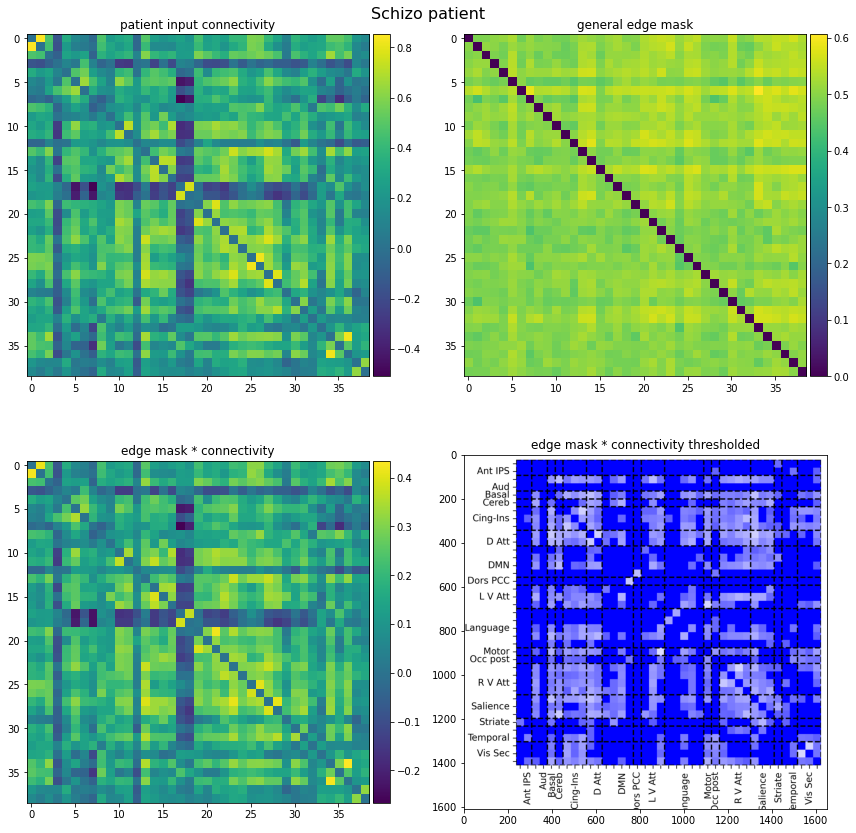

In [168]:
show_results(0, 'negative', '/')

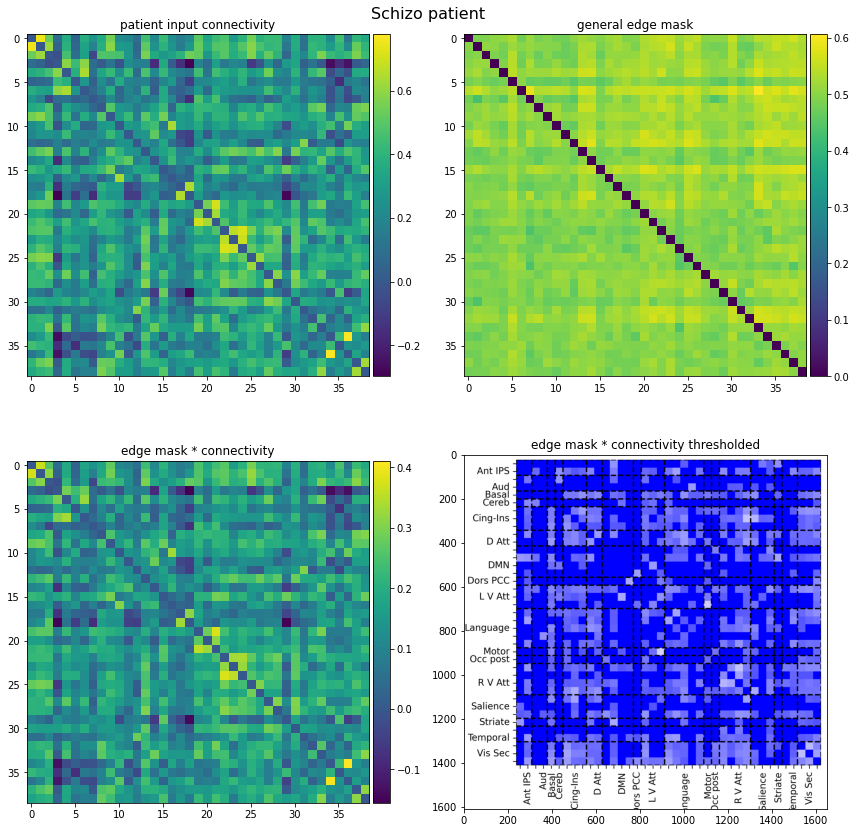

In [169]:
show_results(1, 'positive', '/')

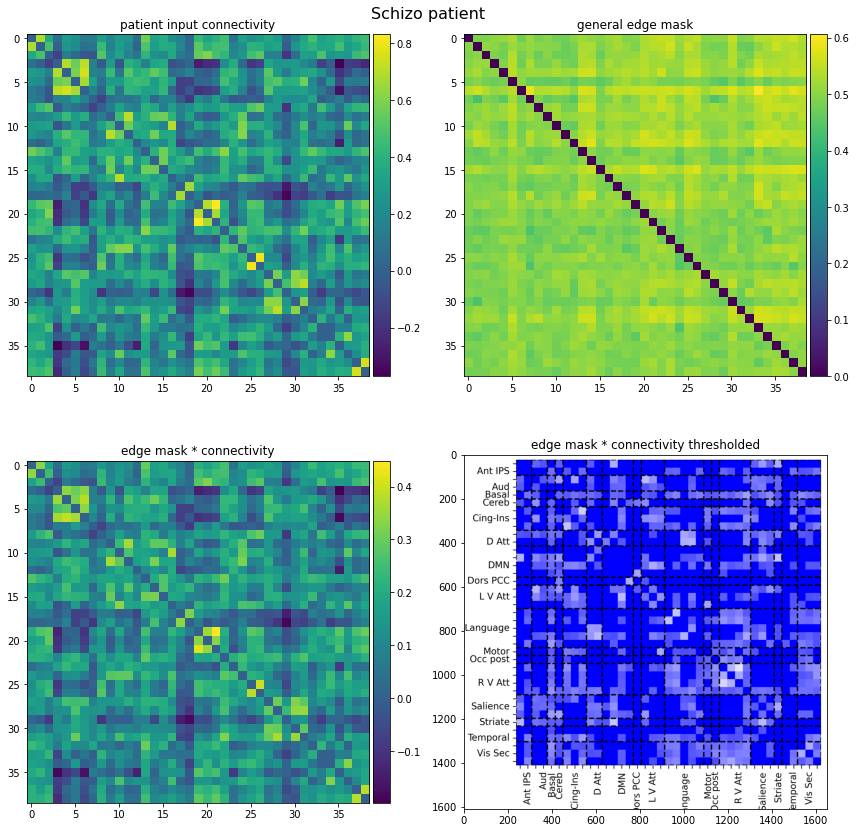

In [171]:
show_results(5, 'negative', '/')

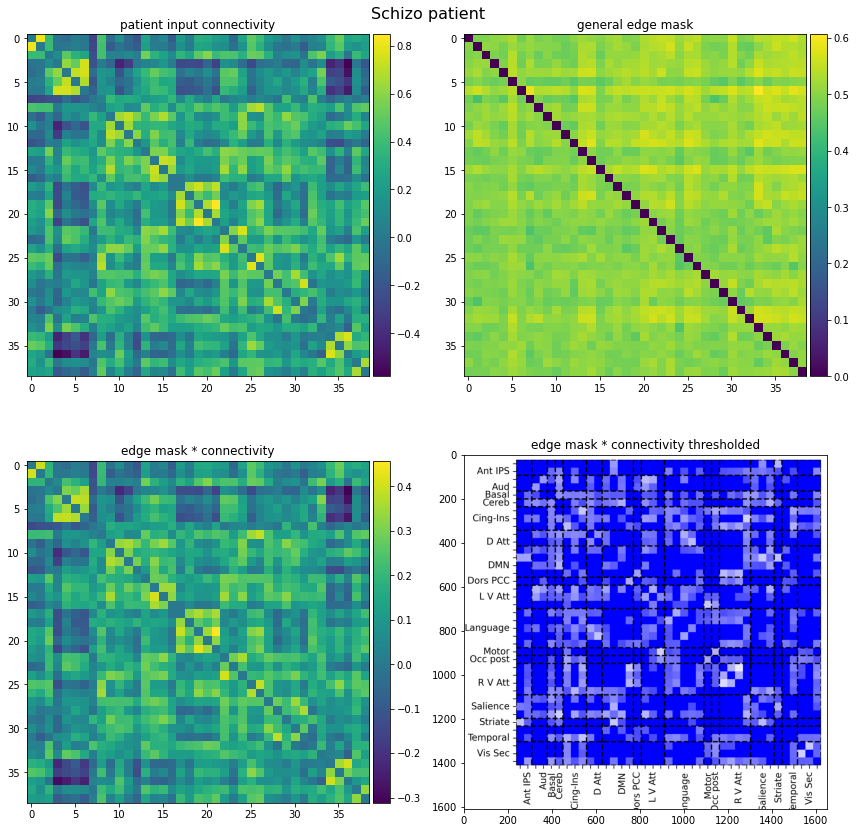

In [172]:
show_results(6, 'positive', '/')

**Edge file** ascii text file with suffix 'edge', representing a connectivity (e.g. correlations) matrix among the ROIs (which could be weighted/binarized) with dimension equal to the number of nodes. 

As the authors, we will use shared edge mask produced by the *explainer* to create an explanation subgraph. To build this subgraph we take the top 100 weighted edges from the masked G with all other edges removed. The connection comparisons will help us identify connections related to specific disorders. 

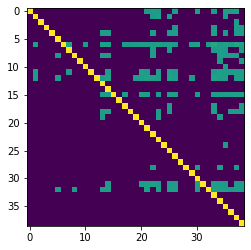

In [71]:
thresh_edgemask = np.loadtxt('./IBGNN_modified/fig/explainer_Schiza_seed123457_thresh100_sharedmask.edge')
plt.imshow(thresh_edgemask)

**Node file**

In [72]:
with open('./datasets/Schiza.node', 'w', encoding='ascii') as f:
    for name in names_map.keys():
        names_map[name]
        tmp = rois[rois.name == name].to_numpy().ravel()
        f.write(f'{tmp[0]}\t{tmp[1]}\t{tmp[2]}\t{cluster_names[tmp[-1]]}\t1\t{names_map[name]}\t\n')

**Salient ROIs**

On the group level, we rank the most salient ROIs on the learned explanation mask by calculating the sum of the edge weights connected to each node. With `nilearn` we plot extracted salient ROIs.

In [98]:
# group level: to rank most salient ROIs on the explanation mask, 
#              we calculate the sum of the edge weights connected to each node.
print('group level ranking')
ranking = {}
for i, row in enumerate(general_edge_mask):
    ranking[list(names_map.keys())[i]] = sum(abs(row))
    
ranking = sorted(ranking.items(), key=lambda a: -a[1])
print(*enumerate(ranking), sep='\n')

group level ranking
(0, ('R DMN', 20.816270142793655))
(1, ('R Post Temp', 20.42113733291626))
(2, ('L DLPFC', 20.37515264749527))
(3, ('Cereb', 20.251688420772552))
(4, ('R Par', 20.189409494400024))
(5, ('Med DMN', 20.039073944091797))
(6, ('R Pars Op', 19.929104894399643))
(7, ('R DLPFC', 19.731136292219162))
(8, ('Motor', 19.72881379723549))
(9, ('L Aud', 19.695139527320862))
(10, ('R IPS', 19.69082561135292))
(11, ('L DMN', 19.63802394270897))
(12, ('L LOC', 19.573585242033005))
(13, ('Broca', 19.53756582736969))
(14, ('R Aud', 19.420884132385254))
(15, ('Striate', 19.327426731586456))
(16, ('R Front pol', 19.292387455701828))
(17, ('L TPJ', 19.271943598985672))
(18, ('L Front pol', 19.153823107481003))
(19, ('Occ post', 19.152420967817307))
(20, ('L STS', 19.07095968723297))
(21, ('L IPS', 19.070838660001755))
(22, ('Sup Front S', 18.998943656682968))
(23, ('Dors PCC', 18.988844245672226))
(24, ('R Ant IPS', 18.94405022263527))
(25, ('L Ant IPS', 18.92345917224884))
(26, ('R LOC'

### Illustrating ROIs

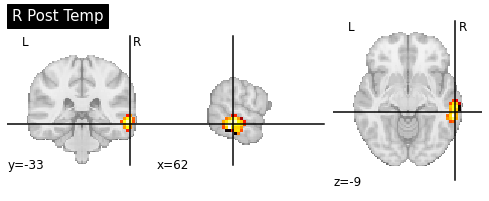

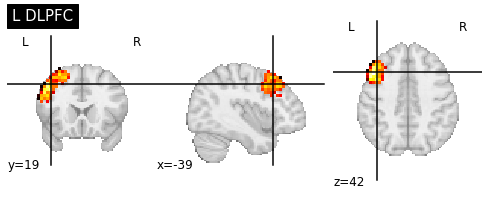

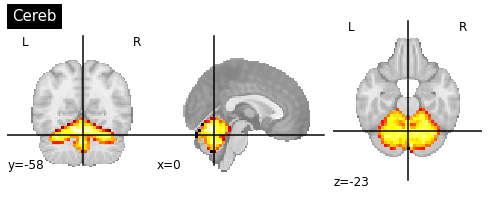

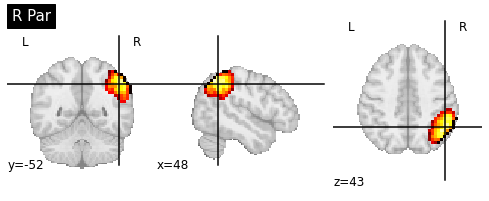

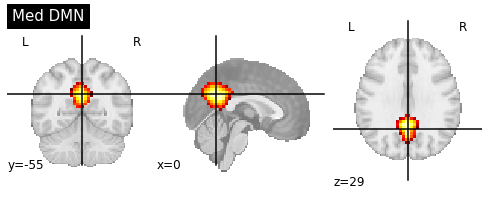

In [115]:
from nilearn import plotting, image, datasets

# First plot the map for the PCC: index 4 in the atlas
for i, rank in enumerate(ranking[1:]):
    plotting.plot_stat_map(image.index_img(atlas_filename, names_map[rank[0]]), 
                           colorbar=False, title=rank[0])
    if i >= 4:
        break


plotting.show()

/root/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
